In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))


## 训练样本拆分

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


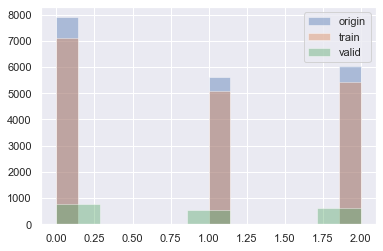

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
sns.distplot(y, label='origin', kde=False, norm_hist=False)
sns.distplot(ytrain, label='train', kde=False, norm_hist=False)
sns.distplot(yvalid, label='valid', kde=False, norm_hist=False)
plt.legend()
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

## 载入GloVec词向量

In [6]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)

print(len(vocabulary))
print(embeddings_index['the'])

29210
[ 2.7204e-01 -6.2030e-02 -1.8840e-01  2.3225e-02 -1.8158e-02  6.7192e-03
 -1.3877e-01  1.7708e-01  1.7709e-01  2.5882e+00 -3.5179e-01 -1.7312e-01
  4.3285e-01 -1.0708e-01  1.5006e-01 -1.9982e-01 -1.9093e-01  1.1871e+00
 -1.6207e-01 -2.3538e-01  3.6640e-03 -1.9156e-01 -8.5662e-02  3.9199e-02
 -6.6449e-02 -4.2090e-02 -1.9122e-01  1.1679e-02 -3.7138e-01  2.1886e-01
  1.1423e-03  4.3190e-01 -1.4205e-01  3.8059e-01  3.0654e-01  2.0167e-02
 -1.8316e-01 -6.5186e-03 -8.0549e-03 -1.2063e-01  2.7507e-02  2.9839e-01
 -2.2896e-01 -2.2882e-01  1.4671e-01 -7.6301e-02 -1.2680e-01 -6.6651e-03
 -5.2795e-02  1.4258e-01  1.5610e-01  5.5510e-02 -1.6149e-01  9.6290e-02
 -7.6533e-02 -4.9971e-02 -1.0195e-02 -4.7641e-02 -1.6679e-01 -2.3940e-01
  5.0141e-03 -4.9175e-02  1.3338e-02  4.1923e-01 -1.0104e-01  1.5111e-02
 -7.7706e-02 -1.3471e-01  1.1900e-01  1.0802e-01  2.1061e-01 -5.1904e-02
  1.8527e-01  1.7856e-01  4.1293e-02 -1.4385e-02 -8.2567e-02 -3.5483e-02
 -7.6173e-02 -4.5367e-02  8.9281e-02  3.3672e

## 用聚类研究词向量间的相似性

In [7]:
frequencies = CountVectorizer().fit(list(xtrain) + list(xvalid)).vocabulary_

# Note: pre-python3.7 dict order is not guaranteed! use Python >= 3.7 for reliable result.
words = np.array(list(embeddings_index.keys()))

vectors = np.array(list(embeddings_index.values()))
vectors = preprocessing.normalize(vectors)

In [8]:
kmeans = KMeans(12, random_state=42).fit(vectors)

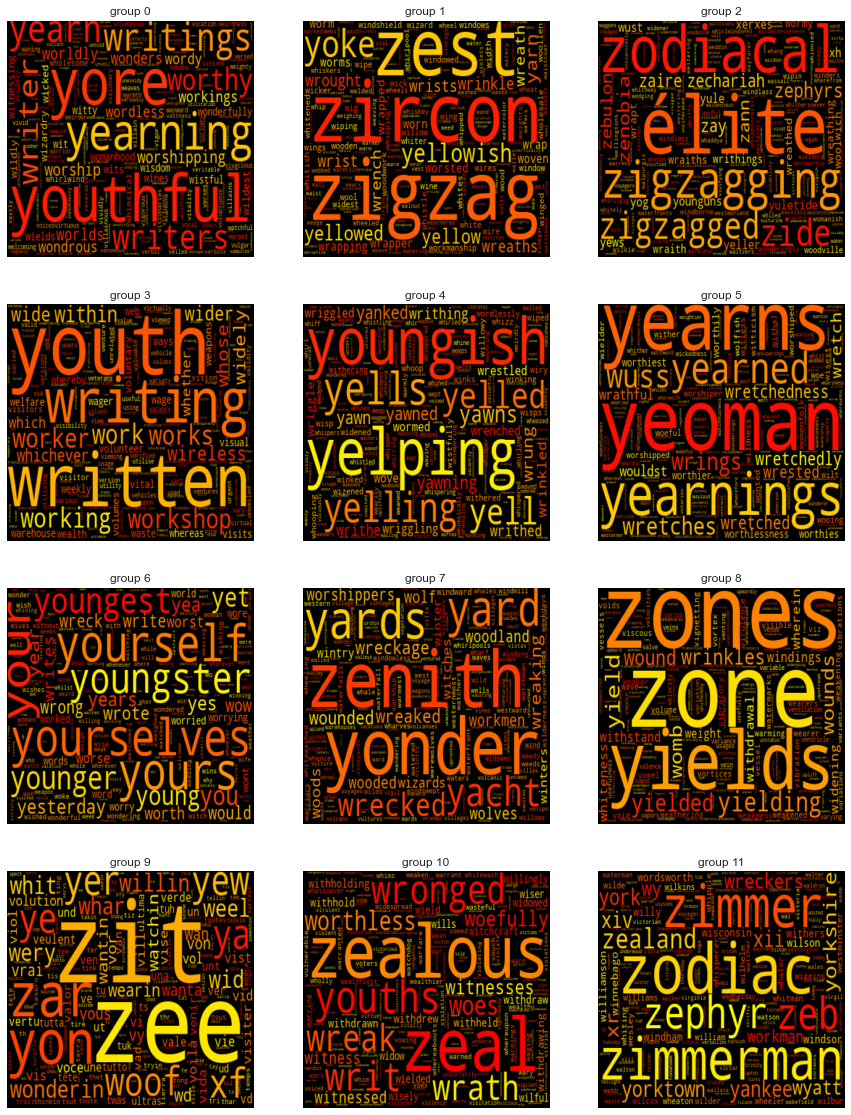

In [9]:
def cloud_label(i, ax):
    cloud=WordCloud(height=300, colormap='autumn')

    labels = kmeans.labels_
    freq = {}
    for w in words[labels==i]:
        if w in frequencies:
            freq[w] = frequencies[w]
    img = cloud.generate_from_frequencies(freq)
    ax.set_title('group ' + str(i))
    ax.imshow(img, interpolation="bilinear", aspect='auto')
    ax.grid(False)
    ax.axis('off')

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
for i, ax in enumerate(np.ravel(axes)):
    cloud_label(i, ax)
plt.subplots_adjust()

## 通过词向量探究近义词

In [10]:
tree = KDTree(vectors)

In [11]:
word_of_interest = 'his'
word_vector = preprocessing.normalize([embeddings_index[word_of_interest]])[0]
distances, neighbors = tree.query(word_vector, k=10)
pd.DataFrame({
    'neighbour': words[neighbors],
    'distance': distances,
})

,neighbour,distance
0,his,5.377488e-08
1,himself,5.828201e-01
2,him,6.028000e-01
3,he,6.451544e-01
4,her,7.275386e-01
5,father,7.859125e-01
6,own,7.915237e-01
7,my,8.379336e-01
8,gave,8.388870e-01
9,their,8.459731e-01


## 特征提取

句子 --> 分词 --> 各词特征向量 --> 由词特征向量计算句向量

In [12]:
def sentence2vec(sentence, stopwords=set()):
    x = np.zeros(len(embeddings_index['a']))
    for w in word_tokenize(sentence):
        if w in stopwords:
            print('stopwords')
            continue
        if w not in embeddings_index:
            continue
        x += embeddings_index[w]
    return preprocessing.normalize([x])[0]

s0 = sentence2vec('this is my book')
s1 = sentence2vec('this is your book')

np.dot(s0, s1)

0.9577612793388115

In [13]:
def sentence_array2vec(a, stopwords=set()):
    out = np.empty((len(a), 300))
    for idx, s in enumerate(a):
        out[idx] = sentence2vec(s)
    return out

## 训练

In [14]:
xtrain_glove_ns = sentence_array2vec(xtrain)
xvalid_glove_ns = sentence_array2vec(xvalid)

train set: logloss: 0.686
valid set: logloss: 0.700
train set
              precision    recall  f1-score   support

         EAP      0.716     0.762     0.739      7110
         HPL      0.735     0.698     0.716      5071
         MWS      0.726     0.700     0.713      5440

    accuracy                          0.725     17621
   macro avg      0.726     0.720     0.723     17621
weighted avg      0.725     0.725     0.724     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.709     0.771     0.739       790
         HPL      0.718     0.683     0.700       564
         MWS      0.712     0.664     0.687       604

    accuracy                          0.712      1958
   macro avg      0.713     0.706     0.709      1958
weighted avg      0.713     0.712     0.712      1958



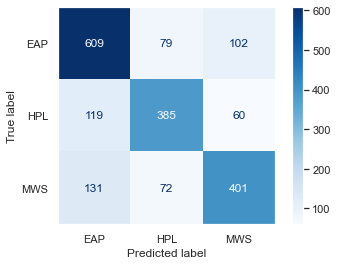

In [15]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'GloVec w/o Stopwords',
    xtrain_glove_ns, ytrain,
    xvalid_glove_ns, yvalid,
)

In [16]:
s = stopwords.words('english')
xtrain_glove = sentence_array2vec(xtrain, s)
xvalid_glove = sentence_array2vec(xvalid, s)

train set: logloss: 0.686
valid set: logloss: 0.700
train set
              precision    recall  f1-score   support

         EAP      0.716     0.762     0.739      7110
         HPL      0.735     0.698     0.716      5071
         MWS      0.726     0.700     0.713      5440

    accuracy                          0.725     17621
   macro avg      0.726     0.720     0.723     17621
weighted avg      0.725     0.725     0.724     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.709     0.771     0.739       790
         HPL      0.718     0.683     0.700       564
         MWS      0.712     0.664     0.687       604

    accuracy                          0.712      1958
   macro avg      0.713     0.706     0.709      1958
weighted avg      0.713     0.712     0.712      1958



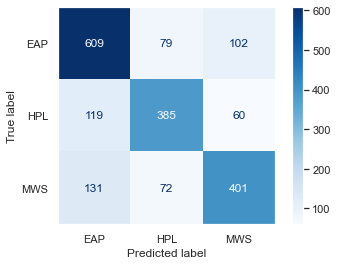

In [17]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'GloVec with Stopwords',
    xtrain_glove, ytrain,
    xvalid_glove, yvalid,
)

In [18]:
history

train            validate          
                        logloss  accuracy   logloss  accuracy
GloVec w/o Stopwords   0.686042  0.720094  0.700169  0.705806
GloVec with Stopwords  0.686042  0.720094  0.700169  0.705806